## 3. Data_download_and_save_to_EOPatches MODIS MCD43A4
#### Final set up for data collection

0. Load required libraries and  site dependant constants and utility functions:
1. Display Greenland contour and selected tiles.
2. Set up Sentinel Hub INSTANCE
4. MODIS data downlaod:
5. MODIS data visualization

### 0. Load required libraries,  area dependant constants and utility functions:


In [1]:
# required libraries:
import os
import geopandas as gpd
from sentinelhub import CRS, BBox
import matplotlib.pyplot as plt
import datetime

# Add to python path parent dictionary
import sys
import numpy as np
sys.path.append("../../")
import matplotlib.pyplot as plt

# load site dependant constants (HERE YOU CAN IMPORT DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

In [3]:
SELECTED_CRS = site.AVAILABLE_CRSs[0]
SELECTED_DATE_RANGE = site.DATE_RANGES_MODIS[19]
SELECTED_PATCHES = site.SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC[SELECTED_CRS.name]

In [4]:
print('You are about to download following data:')
print('SITE_NAME:', site.SITE_NAME)
print('AVAILABLE CRSes:', str(site.AVAILABLE_CRSs))
print('DATA PRODUCTS', str(site.DATA_PRODUCTS))
print('LANDSAT 8 Date ranges:', str(site.DATE_RANGES_LANDSAT_8)) 
print('MODIS Date ranges:', str(site.DATE_RANGES_MODIS[:10])) 
print('SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC:', site.SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC)
# to be continued
print('You have picked: ', SELECTED_CRS )
print('with data range: ', SELECTED_DATE_RANGE )
print('with selected corrdinates in between two points: ', SELECTED_PATCHES)

You are about to download following data:
SITE_NAME: UPE_PROMICE
AVAILABLE CRSes: [<CRS.UTM_22N: '32622'>]
DATA PRODUCTS ['MODIS', 'LANDSAT_8']
LANDSAT 8 Date ranges: [('2013-05-01', '2013-10-31'), ('2014-05-01', '2014-10-31'), ('2015-05-01', '2015-10-31'), ('2016-05-01', '2016-10-31'), ('2017-05-01', '2017-10-31'), ('2018-05-01', '2018-10-31'), ('2019-05-01', '2019-10-31')]
MODIS Date ranges: [('2013-04-26', '2013-11-05'), ('2014-04-26', '2014-11-05'), ('2015-04-26', '2015-11-05'), ('2016-04-26', '2016-11-05'), ('2017-04-26', '2017-11-05'), ('2018-04-26', '2018-11-05'), ('2019-04-26', '2019-11-05'), ('2000-04-26', '2000-11-05'), ('2001-04-26', '2001-11-05'), ('2002-04-26', '2002-11-05')]
SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC: {'UTM_22N': [(3, 140), (7, 130)]}
You have picked:  EPSG:32622
with data range:  ('2012-04-26', '2012-11-05')
with selected corrdinates in between two points:  [(3, 140), (7, 130)]


### 1. Display Greenland contour and selected tiles.

In [5]:
# import tiles from first zone:
gdf = io_utils.load_selected_tiles_from_file(site.SITE_NAME, SELECTED_CRS, site.TILE_SIZE_IN_KM)
gdf.head()
len(gdf)

File exists


55

In [6]:
plot_utils.display_greenland_with_tiles(gdf, SELECTED_CRS, display_indexes=True)

Succesfully loaded Greenland contour. Current CRS: {'init': 'epsg:4326'}
CRS chnaged: {'init': 'EPSG:32622'}


### 2. Set up Sentinel Hub INSTANCE and downlaod EOLearn

In [7]:
from account import kamil9422_sentinel_hub_account as account

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor, OverwritePermission 
from eolearn.io.sentinelhub_service import SentinelHubWCSInput, MimeType, L8L1CWCSInput, DEMWCSInput
from sentinelhub import BBox, CRS, CustomUrlParam, DataSource, WcsRequest
from eolearn.core.core_tasks import SaveTask, LoadTask

 
### 3. MODIS data downlaod:

#### Set up EOTasks for MODIS to calculate NDWI and append with Meta Data

In [318]:
SELECTED_DATE_RANGE

('2012-04-26', '2012-11-05')

In [319]:
class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

In [320]:
# define task for meta info assignment
class AssignMetaInfo(EOTask):   
    """
    The task to assign some additional meta info to the EOPatches:
    """   
    def __init__(self, list_of_feature_names):
        self.list_of_feature_names = list_of_feature_names
        
    def execute(self, eopatch, list_of_features):
        if len(list_of_features) == len(self.list_of_feature_names):
            for i, feature_name in enumerate(self.list_of_feature_names):
                eopatch[FeatureType.META_INFO][feature_name] = list_of_features[i]
        else:
            print('Incorrect number of features:',len(list_of_features),len(self.list_of_feature_names))
        return eopatch

In [321]:
# build EOTask:
custom_script = """return [B01, B02, B03, B04, B05, B06, B07];"""
get_raw_bands_eotask = SentinelHubWCSInput(data_source=DataSource.MODIS,
                                            layer=account.LAYER_NAME_MODIS,
                                            feature=(FeatureType.DATA, 'MODIS_RAW_BANDS'),
                                            image_format=MimeType.TIFF_d32f,
                                            resx='30m', resy='30m',
                                            maxcc=0.05,
                                            time_difference=datetime.timedelta(hours=2),
                                            instance_id=account.INSTANCE_ID_SH,
                                            raise_download_errors=True,
                                            custom_url_params={
                                                    CustomUrlParam.QUALITY: 100,
                                                    CustomUrlParam.EVALSCRIPT: custom_script,
                                                    CustomUrlParam.UPSAMPLING: 'NEAREST'
                                                      })


# creating eo task producing NDWI and application of all eopatches
calculate_ndwi_eotask = NormalizedDifferenceIndex('MODIS_NDWI', 'MODIS_RAW_BANDS/3', 'MODIS_RAW_BANDS/1') # BAND 4 - green and BAND 2 - NIR

add_meta_info_eotask = AssignMetaInfo(list_of_feature_names=['site_name','patch_index','index_x','index_y','maxcc'])

save_dir_eotask = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[0], site.SITE_NAME, site.AVAILABLE_CRSs[0], SELECTED_DATE_RANGE)

save_dir = save_dir = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[0], site.SITE_NAME, site.AVAILABLE_CRSs[0], SELECTED_DATE_RANGE)
print('Data is going to be saved to:', save_dir )
save_eotask = SaveTask(save_dir, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES, compress_level=1)

Data is going to be saved to: ../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2012_04-2012_11/


#### Define EOWorkflow:

In [322]:
workflow_modis = LinearWorkflow(get_raw_bands_eotask, calculate_ndwi_eotask, add_meta_info_eotask, save_eotask)

In [324]:
execution_args = []

for idx, row in gdf.iterrows():
    bbox = BBox(bbox=row['geometry'], crs=site.AVAILABLE_CRSs[0])
    eopatch_name = str(row['index'])+'_maxcc_0.05_x-'+str(row.index_x)+'_y-'+str(row.index_y)
    meta_info_list = [site.SITE_NAME, row['index'], row.index_x, row.index_y, str(0.05)]
    execution_args.append({
        get_raw_bands_eotask: {'bbox' : bbox, 'time_interval': SELECTED_DATE_RANGE },
        add_meta_info_eotask: {'list_of_features': meta_info_list },
        save_eotask: {'eopatch_folder': eopatch_name}
    })

In [325]:
len(execution_args)

55

In [326]:
executor = EOExecutor(workflow_landsat, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()

C:\Users\Kamil\Anaconda3\lib\site-packages\sentinelhub\download\sentinelhub_client.py:50: SHUserWarning: In order to achieve faster download performance please set configuration parameters 'sh_client_id' and 'sh_client_secret'
  warnings.warn(message, category=SHUserWarning)
C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


### 4.  Visualize  exemplary data:

In [8]:
eo_patch = EOPatch.load('../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2013_04-2013_11//2969_maxcc_0.05_x-3_y-130')
eo_patch

EOPatch(
  data: {
    MODIS_NDWI: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 7), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 3
    index_y: 130
    maxcc: '0.05'
    patch_index: 2969
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2013-04-26', '2013-11-05')
  }
  bbox: BBox(((400000.0, 8030000.0), (410000.0, 8040000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2013, 4, 26, 12, 0), ..., datetime.datetime(2013, 11, 5, 12, 0)], length=194
)

2013-04-27 12:00:00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text yticklabel objects>)

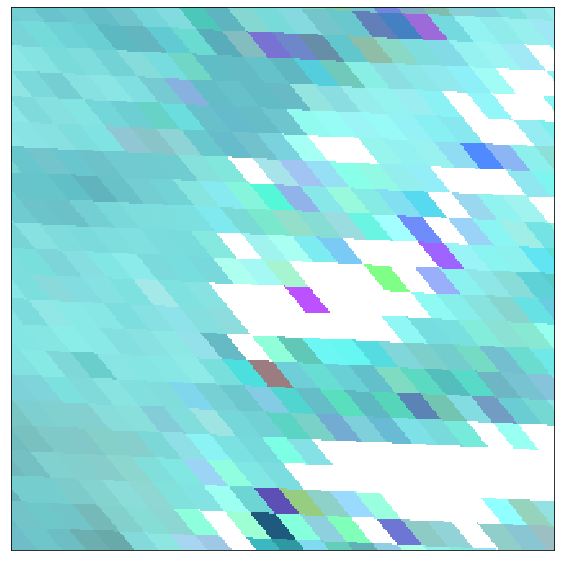

In [9]:
fig = plt.figure(figsize=(10, 10))
print(eo_patch.timestamp[1])
plt.imshow(eo_patch.data['MODIS_RAW_BANDS'][1][..., [4, 3, 2]].squeeze())
plt.xticks([])
plt.yticks([])

2013-04-27 12:00:00


([], <a list of 0 Text yticklabel objects>)

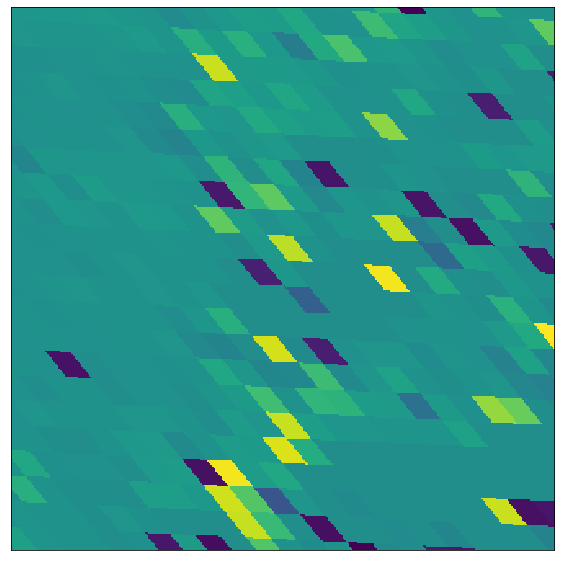

In [10]:
fig = plt.figure(figsize=(10, 10))
print(eo_patch.timestamp[1])
plt.imshow(eo_patch.data['MODIS_NDWI'][1][..., 0].squeeze())
plt.xticks([])
plt.yticks([])